Mounting the drive which contains the dataset zip file and extracting it

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
!pip install patool
import patoolib
#patoolib.extract_archive("/content/drive/MyDrive/archive.zip", outdir="/content/drive/MyDrive/datasets")


We check  the size of a few images, to check if data cleaning is necessary

#Dataset:

The largest publicly available skin lesion hair segmentation mask dataset created by carefully annotating 500 copyright-free CC0 licensed dermoscopic images collected from ISIC 2018 dataset.

The dataset is organized into three folders namely dermoscopic_image, hair_mask, and overlay. The dermoscopic_image folder contains 500 handpicked dermoscopic images covering different hair patterns. We retained the original names of the image files from the primary image source. The hair_mask folder contains a binary segmentation mask for each of the images of the dermoscopic_image folder.

In a segmentation mask image, white pixels represent skin hair and black pixels represent background. The overlay folder contains hair mask images superimposed on the original dermoscopic images. We provided the superimposed images for easy public verification so that, other people can report any annotation mistakes and contribute to improving the dataset. Images in the hair_mask and overlay folders share the same names as the primary images in the dermoscopic_image folder.


In [29]:
import shutil
import os
from sklearn.model_selection import train_test_split

In [30]:
input_dir = "/content/drive/MyDrive/datasets_Lesion/dermoscopic_image"
output_dir = "/content/drive/MyDrive/datasets_Lesion/split"

In [31]:
filenames = os.listdir(input_dir)
train_filenames, test_filenames = train_test_split(filenames, test_size=0.3, random_state=42)
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2, random_state=42)

os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)



In [32]:
for filename in train_filenames:
    shutil.copy(os.path.join(input_dir, filename), os.path.join(output_dir, "train"))
for filename in val_filenames:
    shutil.copy(os.path.join(input_dir, filename), os.path.join(output_dir, "val"))
for filename in test_filenames:
    shutil.copy(os.path.join(input_dir, filename), os.path.join(output_dir, "test"))



##Data cleaning

Omit code as data is self-cleaned to 512x512x3

In [33]:
from PIL import Image
import os

def resize(im, new_width):
    width, height = im.size
    ratio = height / width
    new_height = int(ratio * new_width)
    resized_img = im.resize((new_width, new_height))
    return resized_img


files = os.listdir("/content/drive/MyDrive/Dataset/train/Urticaria Hives")
for file in files:
    im = Image.open("/content/drive/MyDrive/Dataset/train/Urticaria Hives/" + file)
    im = im.convert("RGB")
    im_resized = resize(im, 300)
    filepath = f"/content/drive/MyDrive/Dataset/train/resized_Urticaria Hives/{file[:-4]}.jpg"
    im_resized.save(filepath)

    # Check if the file extension is ".jpg". If not, remove the extra extension.
    file_extension = file[-4:]
    if file_extension != ".jpg":
        new_file_name = file[:-4] + ".jpg"
        os.rename(filepath, f"/content/drive/MyDrive/Dataset/train/resized_Urticaria Hives/{new_file_name}")



##U-Net: For Biomedical Image Segmentation

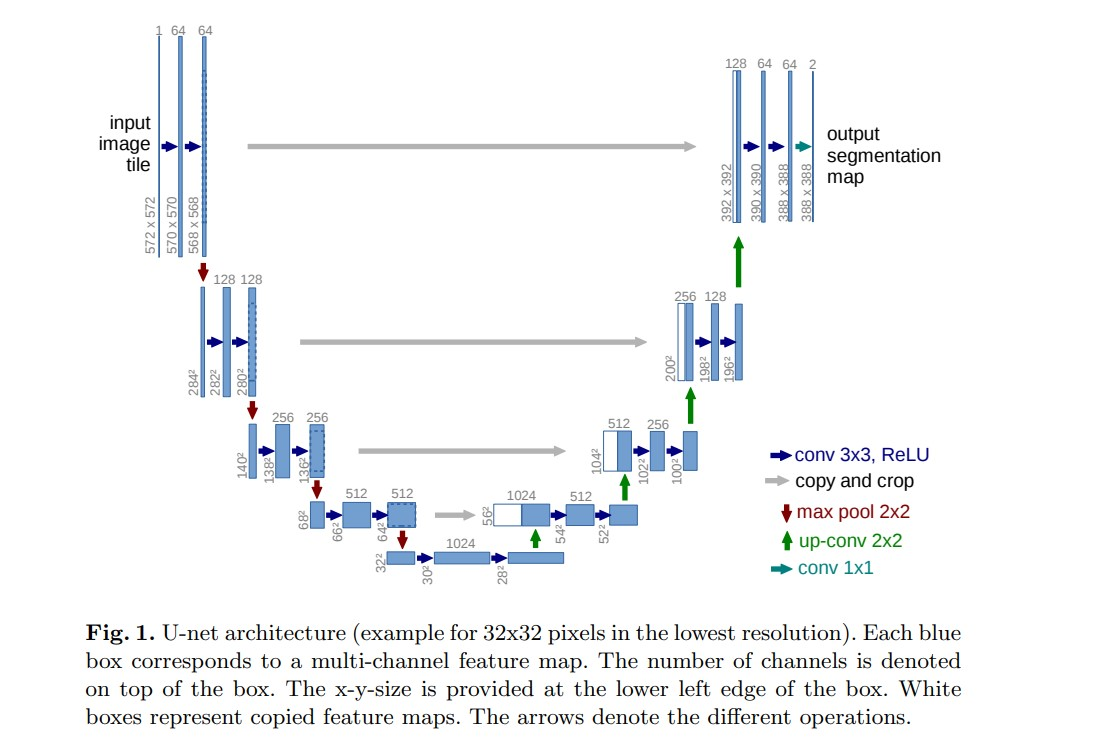

Down sampling & Up sampling shown in the above diagram.


It is an architecture primarily used for Image semantic segmentation, meaning painting the objects in the image as a certain label.



In [34]:
from PIL import Image
import cv2
im = cv2.imread('/content/drive/MyDrive/datasets_Lesion/overlay/ISIC_0000004.png')
print(im.shape)

(512, 512, 3)


Thus (200, 200, 3) is the size of our Images for **Acne and Rosacea**

In [35]:
import tensorflow as tf
import os
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

In [36]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [37]:
TRAIN_PATH = '/content/drive/MyDrive/datasets_Lesion/split/train'
TEST_PATH = '/content/drive/MyDrive/datasets_Lesion/split/val'

train_ids = next(os.walk(TRAIN_PATH))
test_ids = next(os.walk(TEST_PATH))

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [38]:
print('Resizing training images and masks')
"""
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread('/content/drive/MyDrive/datasets_Lesion/split/train' + id_ +  '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/content/drive/MyDrive/datasets_Lesion/split/train/hair_mask'))[2]:
        mask_ = imread(path + '/content/drive/MyDrive/datasets_Lesion/split/train/hair_mask' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
"""

"""
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/content/drive/MyDrive/datasets_Lesion/dermoscopic_image' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
"""
print('Done!')




Resizing training images and masks
Done!


Note: No parameters during Dropout

In [39]:
#from keras.backend import categorical_crossentropy
#Building the model

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

#Convert each pixel to a floating point number
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)


#CONTRACTION PATH
c1 = tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)
print(c1.shape)

c2 = tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2)
print(c2.shape)

c3 = tf.keras.layers.Conv2D(64, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3)
print(c3.shape)

c4 = tf.keras.layers.Conv2D(128, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(c4)
print(c3.shape)

c5 = tf.keras.layers.Conv2D(256, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c5)
print(c5.shape)


#EXTRACTION PATHS
u6 = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(c5)
#u6 = tf.image.crop_to_bounding_box(u6, 1, 1, height-2, width-2)
#u6 = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(u6)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c6)
print(c6.shape)

u7 = tf.keras.layers.Conv2DTranspose(72, (5,5), strides=(2,2), output_padding=(1,1),padding='same')(c6)
#c3 = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(c3)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(72, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(72, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c7)
print(u7.shape)

u8 = tf.keras.layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same')(c7)
#c2 = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(c2)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c8)
print(c8.shape)

u9 = tf.keras.layers.Conv2DTranspose(16, (5,5),strides=(2,2), padding='same')(c8)
#c1 = tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))(c1)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', kernel_initializer='he_normal', padding='same')(c9)
print(c9.shape)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



(None, 512, 512, 16)
(None, 256, 256, 32)
(None, 128, 128, 64)
(None, 128, 128, 64)
(None, 32, 32, 256)
(None, 64, 64, 128)
(None, 128, 128, 136)
(None, 256, 256, 32)
(None, 512, 512, 16)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 512, 512, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  1216        ['lambda_1[0][0]']               
   

In [40]:
#checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_skinnd.h5', verbose=1, save_best_only=True)

In [41]:
#callbacks = [
#    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#    tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/datasets_Lesion')
#]

In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.2,random_state=10)

Fitting the model

In [44]:
results = model.fit(x_train,y_train,batch_size=128,epochs=18,validation_data=(x_val,y_val))

Epoch 1/18


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 512, 512, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 11s 11s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/18
1/1 [==============================] - 0s 365ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/18
1/1 [==============================] - 0s 313ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/18
1/1 [==============================] - 0s 309ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/18
1/1 [==============================] - 0s 295ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/18
1/1 [==============================] - 0s 323ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/18
1/1 [==============================] - 0s 338ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00

In [45]:
results.history

{'loss': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'accuracy': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'val_accuracy': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

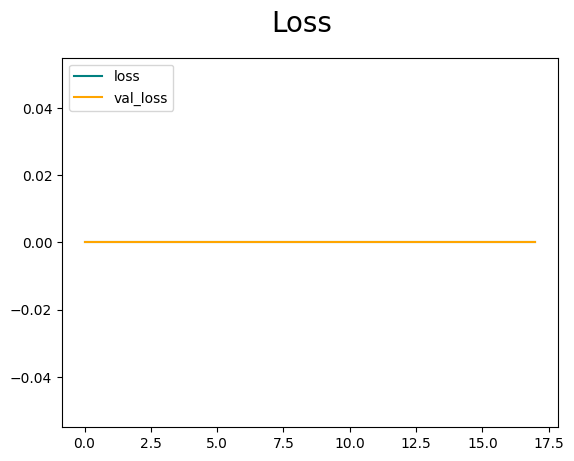

In [46]:
#plot performance
fig=plt.figure()
plt.plot(results.history['loss'],color='teal',label='loss')
plt.plot(results.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [47]:
model.save("/content/drive/MyDrive/datasets_Lesion")

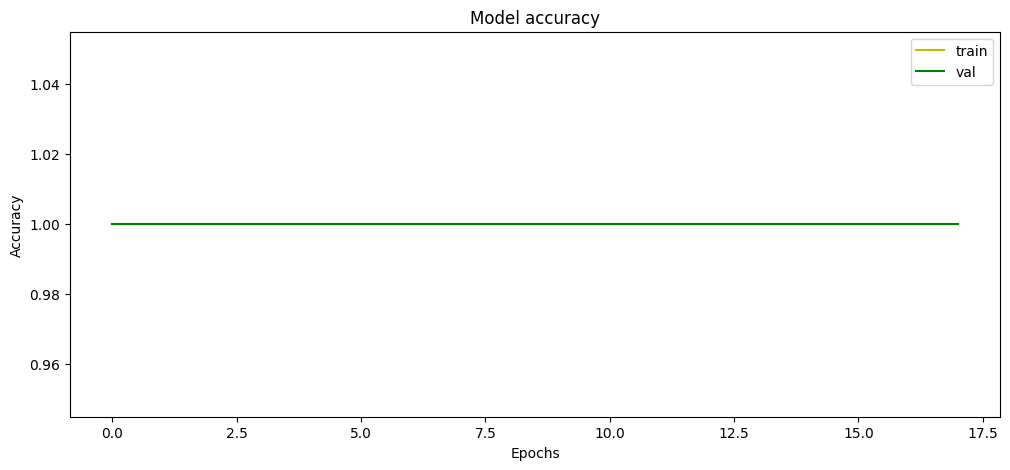

In [48]:
plt.figure(figsize=(12,5))
plt.plot(results.history['accuracy'],color='y')
plt.plot(results.history['val_accuracy'],color='g')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

In [50]:
print("Calculating model accuracy")
scores=model.evaluate(x_val,y_val)
print(f"Test Accuracy :{scores[1]*100}")

Calculating model accuracy
1/1 [==============================] - 0s 81ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Accuracy :100.0


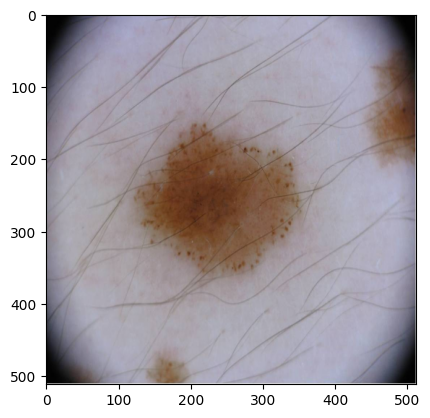

In [51]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
img=cv2.imread('/content/drive/MyDrive/datasets_Lesion/split/test/ISIC_0000069.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

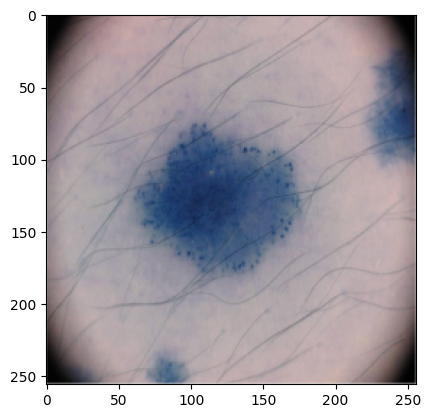

In [52]:
resz=tf.image.resize(img,(256,256))
plt.imshow((resz.numpy().astype(int)))
plt.show()

In [53]:
import numpy as np
np.expand_dims(resz,0)

array([[[[134.5 , 134.5 , 134.5 ],
         [ 97.75,  97.75,  97.75],
         [ 98.  ,  98.  ,  98.  ],
         ...,
         [ 97.5 ,  97.5 ,  97.5 ],
         [ 99.5 ,  99.5 ,  99.5 ],
         [134.75, 134.75, 134.75]],

        [[ 66.5 ,  66.5 ,  66.5 ],
         [  8.  ,   8.  ,   8.  ],
         [  2.  ,   2.  ,   2.  ],
         ...,
         [  1.  ,   1.  ,   1.  ],
         [  0.5 ,   0.5 ,   0.5 ],
         [ 69.  ,  69.  ,  69.  ]],

        [[ 65.5 ,  65.5 ,  65.5 ],
         [  2.  ,   2.  ,   2.  ],
         [  2.5 ,   2.5 ,   2.5 ],
         ...,
         [  1.5 ,   1.5 ,   1.5 ],
         [  2.25,   2.25,   2.25],
         [ 66.  ,  66.  ,  66.  ]],

        ...,

        [[ 66.  ,  66.  ,  66.  ],
         [  3.25,   3.25,   3.25],
         [  2.  ,   2.  ,   2.  ],
         ...,
         [  2.5 ,   2.5 ,   2.5 ],
         [  4.  ,   4.  ,   4.  ],
         [ 65.25,  65.25,  65.25]],

        [[ 65.  ,  65.  ,  65.  ],
         [  3.5 ,   3.5 ,   3.5 ],
         [  

In [ ]:
yhat=model.predict(np.expand_dims(resz/255,0))
yhat